<center><img src="https://raw.githubusercontent.com/openvinotoolkit/anomalib/development/docs/source/images/logos/anomalib-wide-blue.png" alt="Paris" class="center"></center>

<center>💙 A library for benchmarking, developing and deploying deep learning anomaly detection algorithms</center>

---

> NOTE: 
This notebook is originally created by @innat on [Kaggle](https://www.kaggle.com/code/ipythonx/mvtec-ad-anomaly-detection-with-anomalib-library/notebook). 

[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib is a deep learning library that aims to collect state-of-the-art anomaly detection algorithms for benchmarking on both public and private datasets. Anomalib provides several ready-to-use implementations of anomaly detection algorithms described in the recent literature, as well as a set of tools that facilitate the development and implementation of custom models. The library has a strong focus on image-based anomaly detection, where the goal of the algorithm is to identify anomalous images, or anomalous pixel regions within images in a dataset.

The library supports [`MVTec AD`](https://www.mvtec.com/company/research/datasets/mvtec-ad) (CC BY-NC-SA 4.0) and [`BeanTech`](https://paperswithcode.com/dataset/btad) (CC-BY-SA) for **benchmarking** and `folder` for custom dataset **training/inference**. In this notebook, we will explore `anomalib` with `MVTec AD` dataset. 

## Installing Anomalib
Installation can be done in two ways: (i) install via PyPI, or (ii) installing from source. In this notebook, we'll install it from the PyPI version for the sake of simplicity.

In [ ]:
%pip install anomalib

## Imports

In [1]:
import logging
import warnings
from pathlib import Path

import numpy as np

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')
logger = logging.getLogger("anomalib")
from typing import Any, Dict

import numpy as np
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import get_experiment_logger


## Model

Currently, there are **7** anomaly detection models available in `anomalib` library. Namely, 

- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/development/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

In this tutorial, we'll be using Padim. Now, let's get their config paths from the respected folders.

## Configuration

In this demonstration, we will choose [Padim](https://arxiv.org/pdf/2011.08785.pdf) model from the above config; which is index 1 in the above dictionary. Let's take a quick look of its config file. 

In [2]:
MODEL = 'padim' # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = f"../../anomalib/models/{MODEL}/config.yaml"
print(open(CONFIG_PATH, 'r').read())

dataset:
  name: mvtec #options: [mvtec, btech, folder]
  format: mvtec
  path: ./datasets/MVTec
  category: bottle
  task: segmentation
  image_size: 256
  train_batch_size: 32
  test_batch_size: 32
  num_workers: 36
  transform_config:
    train: null
    val: null
  create_validation_set: false
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: padim
  backbone: resnet18
  layers:
    - layer1
    - layer2
    - layer3
  normalization_method: min_max # options: [none, min_max, cdf]
  threshold:
    image_default: 3
    pixel_default: 3
    adaptive: true

metrics:
  image:
    - F1Score
    - AUROC
  pixel:
    - F1Score
    - AUROC

project:
  seed: 42
  path: ./results
  log_images_to: ["local"]
  logger: false # options: [tensorboard, wandb, csv] or combinations.

optimization:
  openvino:
    apply: false

# PL Trainer Args. Don't add extra parameter here.
trainer:
  ac

We could use [get_configurable_parameter](https://github.com/openvinotoolkit/anomalib/blob/development/anomalib/config/config.py#L114) function to read the configs from the path and return them in a dictionary. We use the default config file that comes with PatchCore implementation, which uses `./datasets/MVTec` as the path to the dataset. We need to overwrite this after loading the config.

In [3]:
# pass the config file to model, logger, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)
config["dataset"]["path"] = "../../datasets/MVTec"     # or wherever the MVTec dataset is stor.

## Dataset: MVTec AD

**MVTec AD** is a dataset for benchmarking anomaly detection methods with a focus on industrial inspection. It contains over **5000** high-resolution images divided into **15** different object and texture categories. Each category comprises a set of defect-free training images and a test set of images with various kinds of defects as well as images without defects. If the dataset is not located in the root datasets directory, anomalib will automatically install the dataset.

We could now import the MVtec AD dataset using its specific datamodule implemented in anomalib.

In [4]:
datamodule = get_datamodule(config)
datamodule.setup()          # Downloads the dataset if it's not in the specified `root` directory
datamodule.prepare_data()   # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
data.keys()

dict_keys(['image', 'image_path', 'label', 'mask_path', 'mask'])

Let's check the shapes of the input images and masks.

In [5]:
data["image"].shape, data["mask"].shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

We could now visualize a normal and abnormal sample from the validation set.

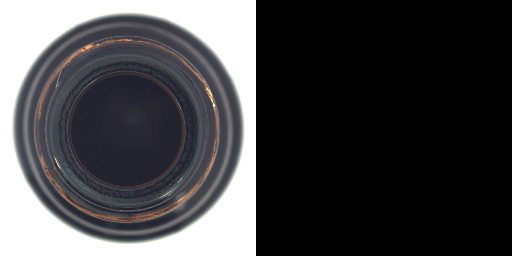

In [6]:
def show_image_and_mask(data: Dict[str, Any], index: int) -> Image:
    img = ToPILImage()(Denormalize()(data["image"][index].clone()))
    msk = ToPILImage()(data["mask"][index]).convert("RGB")

    return Image.fromarray(np.hstack((np.array(img), np.array(msk))))

# Visualize a normal image-mask
show_image_and_mask(data, index=0)

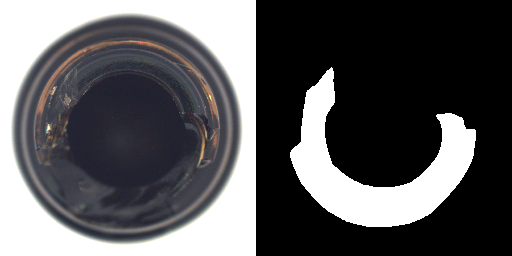

In [7]:
# Visualize an abnormal image-mask
show_image_and_mask(data, index=20)

## Prepare Model, Callbacks and Loggers
Now, the config file is updated as we want. We can now start model training with it.

In [8]:
model = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks = get_callbacks(config)

In [9]:
# start training
trainer = Trainer(**config.trainer, logger=experiment_logger, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

MisconfigurationException: `Trainer(strategy='ddp_spawn')` or `Trainer(accelerator='ddp_spawn')` is not compatible with an interactive environment. Run your code as a script, or choose one of the compatible strategies: Trainer(strategy=None|dp|tpu_spawn). In case you are spawning processes yourself, make sure to include the Trainer creation inside the worker function.

## Validation - Quantitative Performance

In [ ]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(
    weights_path=trainer.checkpoint_callback.best_model_path
)
trainer.callbacks.insert(0, load_model_callback)
trainer.test(model=model, datamodule=datamodule)

## Validation - Qualitative Performance
By default, the output images are saved into `results` directory. We could get the output filenames from the directory, read the saved the images and visualize here. 

In [ ]:
config["project"]["path"]

In [ ]:
image_filenames = [filename for filename in Path(config["project"]["path"]).glob("**/*.png")]
image_filenames[0]

In [ ]:
for filename in image_filenames:
    image = Image.open(filename)
    display(image)